In [5]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [90]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [9]:
with open('../data/molecules.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [10]:
structures = pd.read_feather('../data/structures.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

1JHC score: 1.6866479972723665
1JHN score: 1.293631856186129
2JHC score: 0.7803140457396459
2JHH score: 0.9065723188298769
2JHN score: 1.2080966868669898
3JHC score: 0.9044183085778488
3JHH score: 1.1896842082745829
3JHN score: 0.0923684542670776


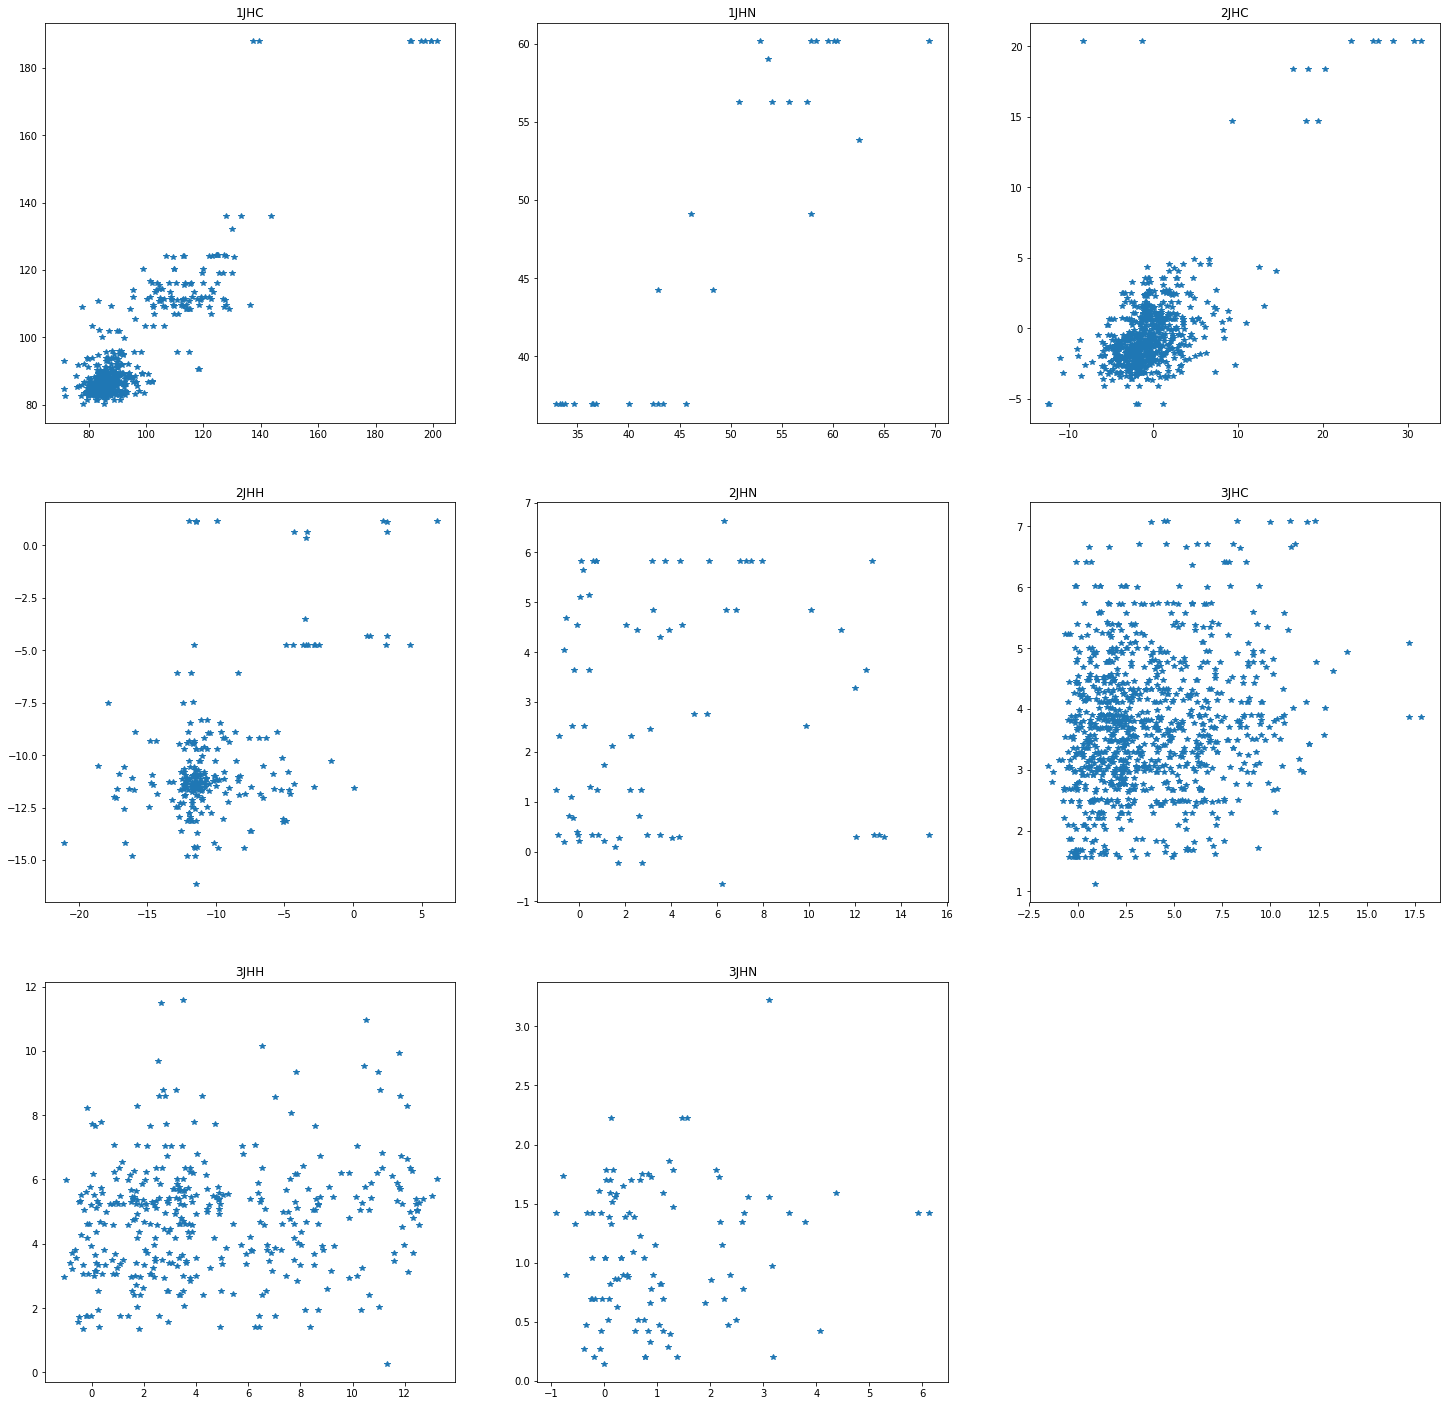

In [128]:
from models import XGBModel, LGBModel
from models import partition_data

def test(data):
    plt.figure(figsize=(25, 25))
    for i, t in enumerate(sorted(data.type.unique()), 1):
        data_df = data[data.type == t]
        train_df, test_df = partition_data(data_df)
        
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(objective='regression',
                              n_jobs=8,
                              max_depth=9,
                              boosting_type='gbdt',
                              num_leaves=128,
                              #min_child_samples=79,
                              n_estimators=1000))
        
        model.fit(train_df, train_df)
        output, score = model.evaluate(test_df, test_df)
        print(f'{t} score: {score}')
        plt.subplot(3, 3, i)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        plt.title(t)
    plt.show()
        
test(labelled.sample(10000))